Group number: **33**  
**Lynn Le, s4596390**  
**Ankur Ankan, s4753828**  
**Eleonora Scarfo, s1028886**  
**Virginia Meijer, s1024024** 

**SOW-MKI49: Neural Information Processing Systems**

**Assignment 5: Neural Decoding**

**Total points: 100**

**Author: Umut**

In this assignment, you will implement a neural decoder for reconstructing perceived stimuli from brain responses. We will be using the dataset that was previously used in a number of papers. These papers along with additional lecture notes on neural decoding can be found in Brightspace. You can refer them for more details on the dataset and/or the method.

The dataset contains fMRI data acquired from the early visual cortex of one subject as the subject was presented with 100 grayscale images of handwritten sixes and nines (50 sixes and 50 nines). The fMRI data has been realigned and slice time corrected. Furthermore, stimulus specific response amplitudes have been estimated with a general linear model.

Let's first familiarize ourselves with the dataset. It contains a number of variables:

* **X** -> This is a 100 x 784 matrix. The ith row contains the pixel values of the stimulus that was presented in the ith trial of the experiment. Note that the stimuli are 28 pixel x 28 pixel images, which were reshaped to 1 x 784 vectors.

* **Y** -> This is a 100 x 3092 matrix. The ith row contains the voxel values of the responses that were measured in the ith trial of the experiment.

* **X_prior** -> This is a 2000 x 784 matrix. Each row contains the pixel values of a different stimulus, which was not used in the experiment. Note that the stimuli are 28 pixel x 28 pixel images, which were reshaped to 1 x 784 vectors.

Note: In the remainder of this document, we will use **x** for referring to a 784 x 1 stimulus vector and **y** for referring to a 3092 x 1 response vector.

## Task 1 (10 points)

* Load the dataset.
* Visualize some of the stimuli.
* Normalize X and Y to have zero mean and unit variance. Tip: Recall that normalization means subtracting the mean of each pixel/voxel from itself and dividing it by its standard deviation. You can use zscore function.
* Split X and Y in two parts called X_training and X_test, and Y_training and Y_test. The training set should contain 80 stimulus-response pairs (40 pairs for sixes and 40 pairs for nines). The test set should contain 20 stimulus-response pairs (10 pairs for sixes and 10 pairs for nines).

In [0]:
!apt -y -q install cuda-libraries-dev-9-2
!pip install -q cupy-cuda92 chainer

Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-9-2 is already the newest version (9.2.148-1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
!git clone https://github.com/lelynn/nips_2018

Cloning into 'nips_2018'...
remote: Enumerating objects: 55, done.
remote: Total 55 (delta 0), reused 0 (delta 0), pack-reused 55
Unpacking objects: 100% (55/55), done.


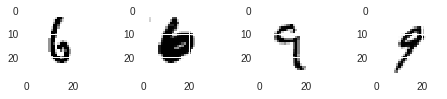

In [0]:
#task 1

###
from scipy import stats
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

#Visualizing the data
data = sio.loadmat('nips_2018/assigment_5/69dataset2.mat')
X = data['X']
Y = data['Y']
X_prior = data['X_prior']

stimuli = X.reshape(100,28,28)

samples = [stimuli[1], stimuli[3], stimuli[50], stimuli[90]]

for i in range(4):
    plt.subplot(4,4,i+1)
    s = np.transpose(np.reshape(samples[i], (28,28)))
    plt.imshow(s)

plt.show()

#Normalizing
X_norm = stats.zscore(X, 1)
Y_norm = stats.zscore(Y, 1)

#Splitting the data into trainingset and testset
X_training = np.concatenate((X_norm[:40],X_norm[50:90]))
X_test = np.concatenate((X_norm[40:50],X_norm[90:]))
Y_training = np.concatenate((Y_norm[:40],Y_norm[50:90]))
Y_test = np.concatenate((Y_norm[40:50],Y_norm[90:]))

###

Our goal is to solve the problem of reconstructing **x** from **y**. One possible approach to solve this problem is to use a *discriminative* model. Discriminative models predict **x** as a function of **y**. That is:

**x** = f(**y**)

We will assume that f is a linear function. That is:

**x** = **B'** **y**

f can be seen as a very simple linear neural network comprising one layer of weights (i.e., **B**). We can estimate **B** in close form with ridge regression. That is:

**B** = inv(**Y**\_training' **Y**\_training + lambda **I**) **Y**\_training' **X**\_training

where lambda is the regularization coefficient, **I** is the *q* x *q* identity matrix, and *q* is the number of voxels. Note that we can safely ignore the intercept since we normalized our data to have zero mean and unit variance.

## Task 2  (15 points)

* Estimate **B** on the training set. Tip: Normally, you should use cross validation to estimate lambda. For simplicity, you can assume that lambda = 10 ^ -6.
* Reconstruct **x** from **y** in the test set.
* Visualize the reconstructions.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


B_x: (3092, 784)


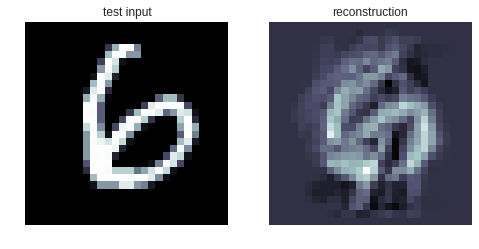

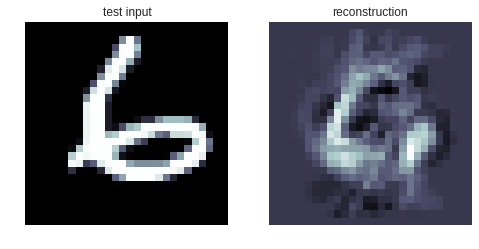

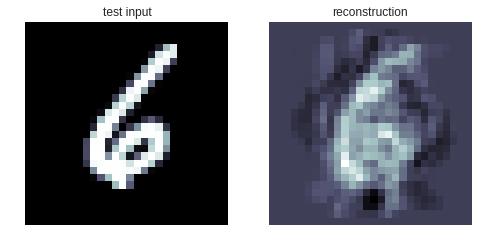

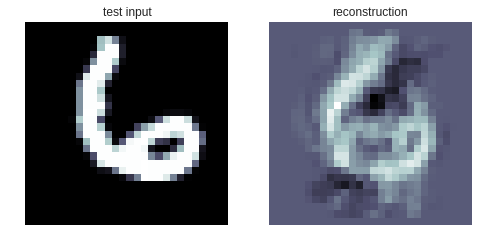

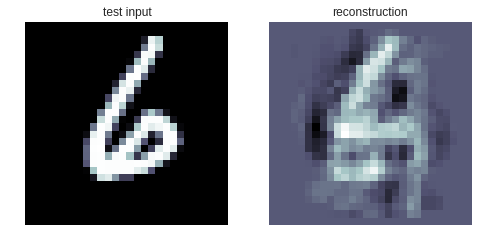

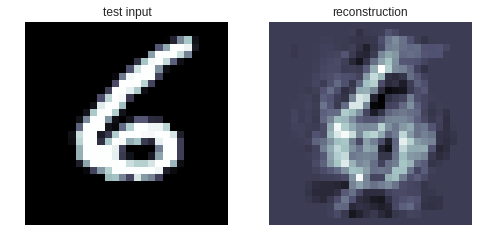

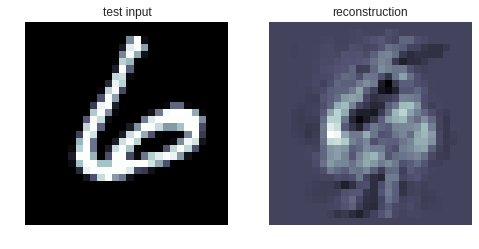

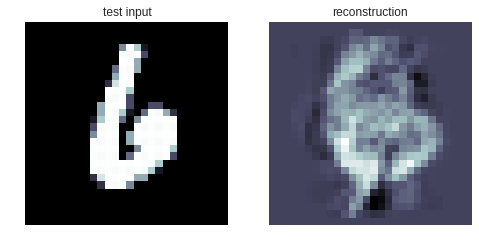

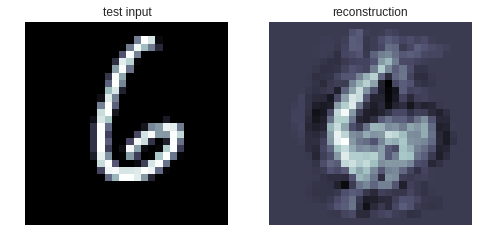

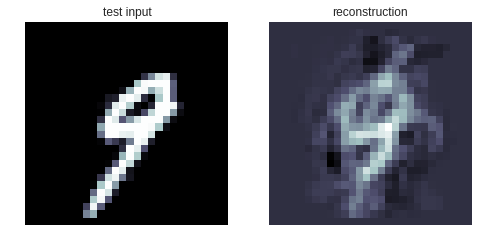

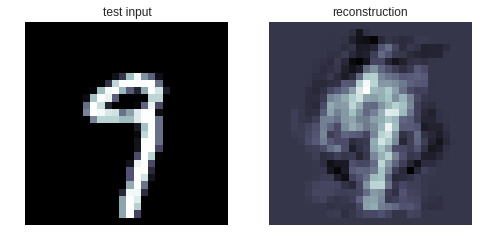

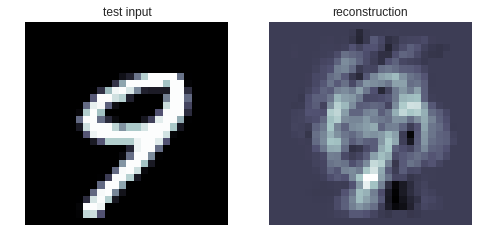

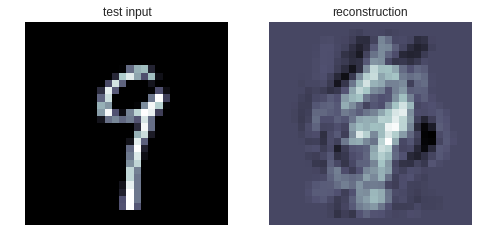

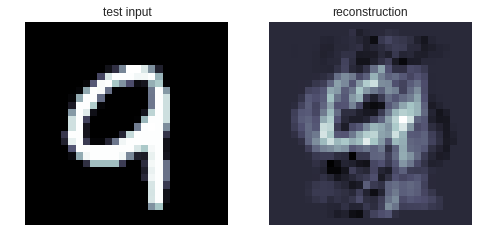

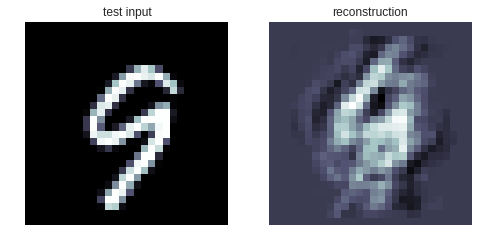

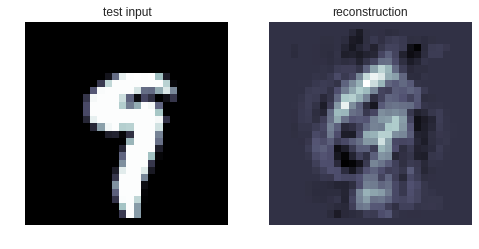

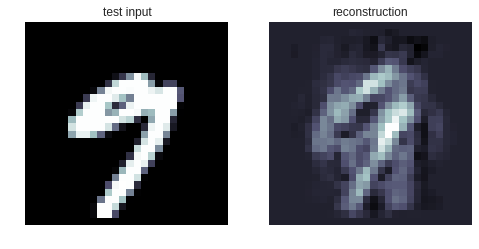

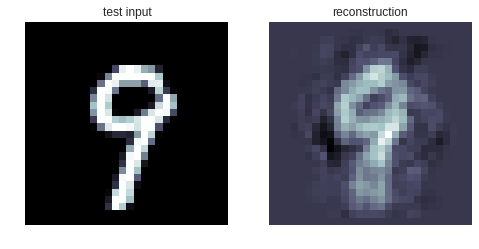

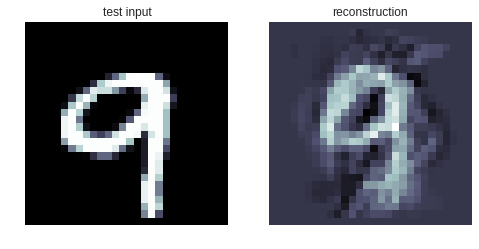

In [0]:
#Task 2

###

lambd = 10**-6
q = Y_training.shape[1]
I = np.identity(q)

B_x = np.linalg.lstsq(np.dot(Y_training.T,Y_training) + np.dot(lambd,I), np.dot(Y_training.T,X_training))[0]
print('B_x:',B_x.shape)

for i in range(1,20):

    plt.subplot(1,2,1)
    plt.title('test input')
    plt.axis('off')
    plt.imshow(np.reshape(X_test[i,:],(28,28),order='F'),cmap='bone')

    X_reconstruction = np.dot(Y_test,B_x)

    plt.subplot(1, 2, 2)
    plt.title('reconstruction')
    plt.axis('off')
    plt.imshow(np.reshape(X_reconstruction[i, :],(28, 28),order='F'), cmap='bone')

    plt.show()

###

Another possible approach to solve the problem of reconstructing **x** from **y** is to use a *generative* model and invert it with Bayes' rule. We reformulate the problem as finding the most probable **x** that could have caused **y**. That is:

argmax_**x** P(**x** | **y**)

where P(**x** | **y**) is called the posterior (probability of the stimulus being **x** if the observation is **y**). In other words, we have to define the posterior, estimate its parameters and find the argument that maximizes it, which will be the reconstruction of **x** from **y**. While, this may seem daunting, it actually has a simple solution. The posterior assigns a probability to an event by combining our observations and beliefs about it, and can be decomposed with Bayes' rule as the product of how likely our observations are given the event (probability of observing **y** if the stimulus is **x**) and how likely the event is independent of our observations (probability of the stimulus being **x**). That is:

P(**x** | **y**) ~ P(**y** | **x**) * P(**x**)

where P(**y** | **x**) is called the likelihood and P(x) is called the prior.

We will assume that the likelihood and the prior are multivariate Gaussian distributions. A Gaussian is characterized by two parameters: a mean vector and a covariance matrix. In the case of the likelihood, the mean of the Gaussian is given by:

**mu**\_likelihood = **B'** **x**

As before, we can estimate **B** in close form with ridge regression:

**B** = inv(**X**\_training' **X**\_training + lambda **I**) **X**\_training' **Y**\_training

where lambda is the regularization coefficient, I is the *p* x *p* identity matrix, and *p* is the number of pixels. The covariance matrix of the likelihood is given by:

**Sigma**_likelihood = diag(E[||**y** - **B'** **x**|| ^ 2]). 

In the case of the prior, the mean of the Gaussian is given by:

**mu**\_prior = **0** (which is a vector of zeros)

The covariance matrix of the prior is given by:

**Sigma**\_prior = **X**\_prior' * **X**\_prior / (n - 1)

where n is the length of **X**\_prior.

## Task 3 (20 points)

* Estimate **B** on the training set. Tip: Normally, you should use cross-validation to estimate lambda and Sigma_likelihood. For simplicity, you can assume that lambda = 10 ^ -6 and Sigma_likelihood = 10 ^ -3 **I**.
* Estimate **Sigma**\_prior. Tip: Add 10 ^ -6 to the diagonal of Sigma_prior for regularization.
* Visualize **Sigma**\_prior. Can you explain what it shows?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


B_Y_shape: (784, 3092)


(-0.5, 783.5, 783.5, -0.5)

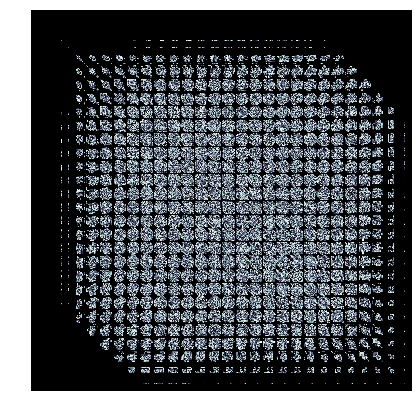

In [0]:
#Task 3
###
lambd = 10**-6
p = X_training.shape[1]
Sigma_likelihood = 10**-3 * np.identity(q)

#Estimate B on training set:

B_y = np.linalg.lstsq(np.linalg.multi_dot([X_training.T, X_training + lambd, np.identity(p)]), np.dot(X_training.T , Y_training))[0]
print('B_Y_shape:', B_y.shape)

# Estimate sigma_prior:
n = len(X_prior)

# Sigma_prior = (np.dot(X_prior.T, X_prior))/np.add((n-1),np.dot(lambd,np.identity(p)))
Sigma_prior = (np.dot(X_prior.T, X_prior) / (n-1)) + lambd * np.identity(p)

# Visualize sigma_prior:
plt.figure(figsize=(7,7))

plt.imshow(Sigma_prior, cmap = 'bone' )
plt.axis('off')

#This is a 2000 x 784 matrix. Each row contains the pixel values of a different stimulus, which was not used in the experiment. 


###

Having defined the likelihood and the prior as Gaussians, we can derive the posterior by multiplying them. It turns out that the product of two Gaussians is another Gaussian, whose mean vector is given by:

**mu**\_posterior = inv(inv(**Sigma**\_prior) + **B** inv(**Sigma**\_likelihood) **B**') **B** * inv(**Sigma**\_likelihood) **y**

We are almost done. Recall that the reconstruction of **x** from **y** is the argument that maximizes the posterior, which we derived to be a Gaussian. We will be completely done once we answer the following question: What is the argument that maximizes a Gaussian?

.  
.  
.  
.  
.  
.

The answer is its mean vector, which is the solution of our initial problem. That is:

argmax_**x** P(**x** | **y**) =  
**mu**\_posterior =  
inv(inv(**Sigma**\_prior) + **B** inv(**Sigma**\_likelihood) **B**') **B** * inv(**Sigma**\_likelihood) **y**

Now, we can plug any **y** in the above equation and reconstruct the most probable **x** that could have caused it.


## Task 4 (25 points)

- Reconstruct **x** from **y** in the test set.
- Visualize the reconstructions.
- Compare the reconstructions with the earlier reconstructions. Which one is better? Why? Can you think of ways to improve the results?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to k

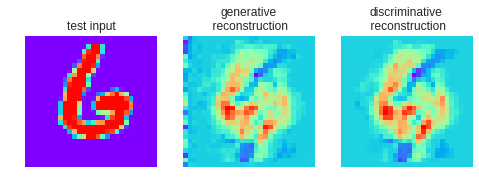

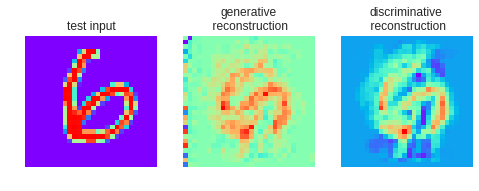

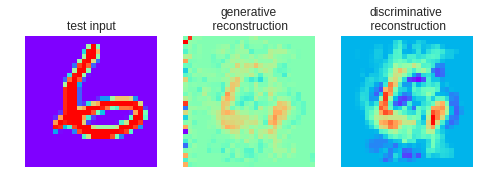

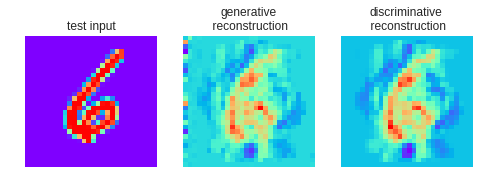

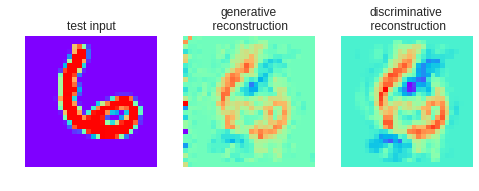

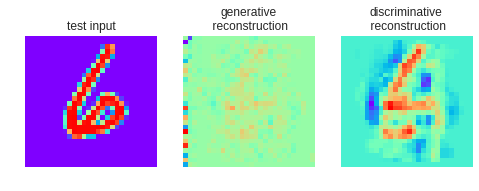

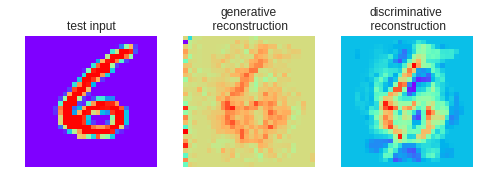

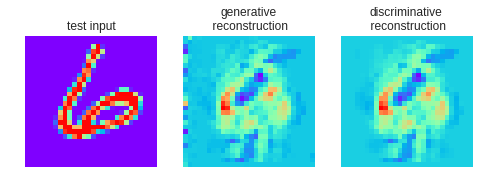

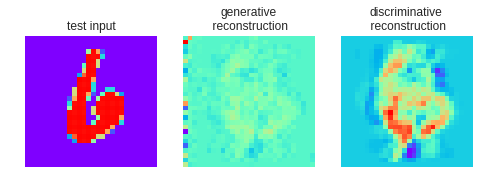

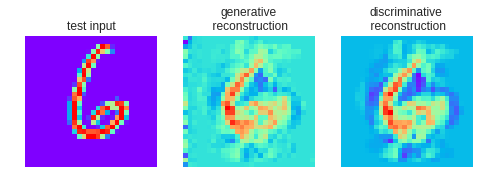

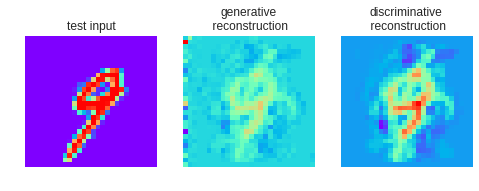

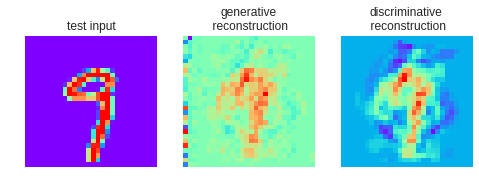

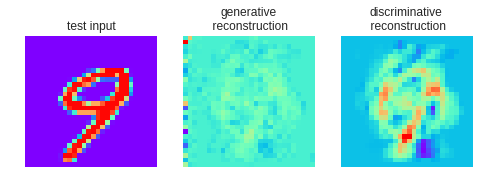

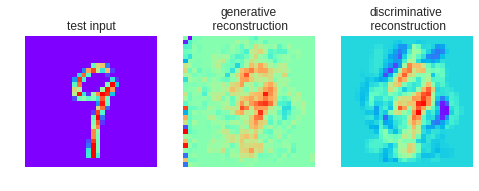

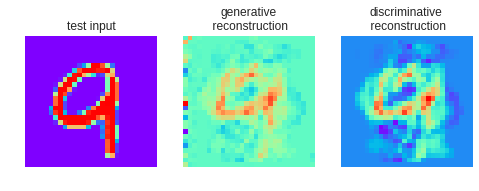

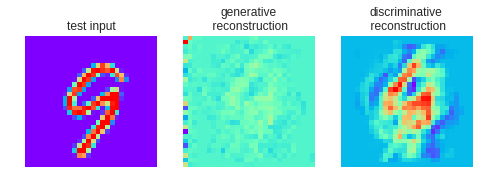

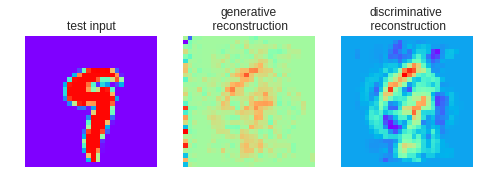

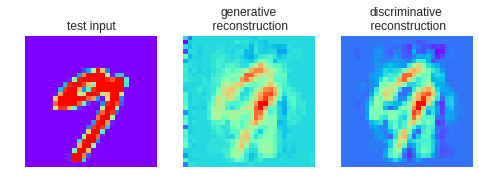

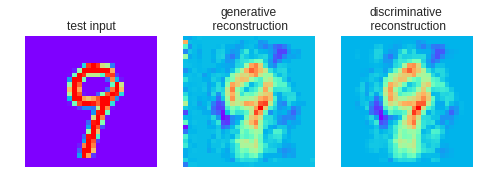

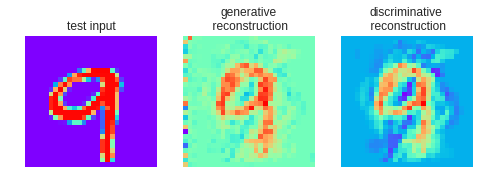

In [0]:
#Task4
###
p = Y_test.shape[1]
I = np.identity(p)
Sigma_likelihood = np.dot(10**-3,I)

post_A = np.linalg.lstsq(Sigma_prior,np.ones(Sigma_prior.shape))[0] + np.dot(np.linalg.lstsq(np.transpose(Sigma_likelihood), B_y.T)[0].T,np.transpose(B_y))
post_B = np.dot(np.linalg.lstsq(np.transpose(Sigma_likelihood),np.transpose(B_y))[0].T,Y_test.T)

X_from_Y_test = np.linalg.lstsq(post_A,post_B)[0]
X_from_Y_test = np.transpose(X_from_Y_test)

cmap = 'rainbow'

for i in range(0,20):    
    
    plt.subplot(1,3,1)
    plt.title('test input')
    plt.axis('off')
    plt.imshow(np.reshape(X_test[i],(28,28),order='F'), cmap=cmap)

    X_from_Y_reconstruction = X_from_Y_test[i,:]
    
    plt.subplot(1,3,2)
    plt.title('generative\n reconstruction')
    plt.axis('off')

    plt.imshow(np.reshape(X_from_Y_reconstruction,(28,28), order = 'F'), cmap=cmap)

    plt.subplot(1,3,3)
    plt.title('discriminative\n reconstruction')
    plt.axis('off')
    plt.imshow(np.reshape(X_reconstruction[i,:],(28,28),order='F'), cmap=cmap)
               
    plt.show()


###

Now the real fight begins! You might have already realized that the second approach is very similar to the one in the face reconstruction paper that we have discussed in the last lecture. The main difference is how the stimuli are encoded. So far, we have been encoding the stimuli with an identity transformation:

**mu**\_likelihood = **B'** g(**x**)

where g(**x**) = **x**

In the paper, they are encoded as the features extracted from a DNN:

**mu**\_likelihood = **B'** DNN(**x**)

Similarly, we have been decoding the responses with MAP estimation of the stimuli:

g ^ -1(argmax_g(**x**) P(g(**x**) | **y**))

where g ^ -1(**y**) = **y**

In the paper, they are decoded with MAP estimation of the features followed by an inverse DNN:

DNN ^ -1(argmax_DNN(**x**) P(DNN(**x**) | **y**))

## Task 5 (30 points)

- Train a simple DNN for digit classification on the MNIST dataset.
- Select an indermediate layer of the DNN as your feature extractor.
- Train another simple DNN to invert the first DNN. That is, it should transform features extracted by the selected layer of the first DNN to stimuli.
- Repeat Task 3 but use the trained DNNs instead of identity transformation.

In [0]:
import matplotlib.pyplot as plt
import chainer

from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
import chainer.datasets as D
from chainer.training import extensions
from chainer.dataset import concat_examples
from chainer.backends.cuda import to_cpu

import cupy as cp

In [0]:
# Download the MNIST data
train, test = D.mnist.get_mnist(withlabel=True, ndim=1)

label: 5


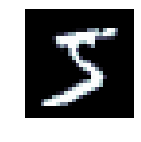

In [0]:
# Display an example from the MNIST dataset.
# `x` contains the input image array and `t` contains that target class

x_train, t_train = train[0]
x_test, t_test = test[0]

plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(x_train.reshape(28, 28), cmap='bone')
print('label:', t_train)

In [0]:
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize,
                                     repeat=False, shuffle=False)

In [0]:
# Implement the neural network for your competition here:
class SimpleNetwork(Chain):
    def __init__(self, n_mid_units=100, n_out=10):
        super(SimpleNetwork, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)

    def forward(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        return F.softmax(self.l3(h))

    def extract_l2(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        return h

model = SimpleNetwork()
model.to_gpu()


In [0]:
# Choose an optimizer algorithm
optimizer = optimizers.MomentumSGD(lr=0.01, momentum=0.9)

# Give the optimizer a reference to the model so that it
# can locate the model's parameters.
optimizer.setup(model)

In [0]:
gpu_id = 0

max_epoch = 25

while train_iter.epoch < max_epoch:

    # ---------- One iteration of the training loop ----------
    train_batch = train_iter.next()
    image_train, target_train = concat_examples(train_batch, gpu_id)

    # Calculate the prediction of the network
    prediction_train = model(image_train)

    # Calculate the loss with softmax_cross_entropy
    loss = F.softmax_cross_entropy(prediction_train, target_train)

    # Calculate the gradients in the network
    model.cleargrads()
    loss.backward()

    # Update all the trainable parameters
    optimizer.update()
    # --------------------- until here ---------------------

    # Check the validation accuracy of prediction after every epoch
    if train_iter.is_new_epoch:  # If this iteration is the final iteration of the current epoch

        # Display the training loss
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='')

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            image_test, target_test = concat_examples(test_batch, gpu_id)

            # Forward the test data
            prediction_test = model(image_test)

            # Calculate the loss
            loss_test = F.softmax_cross_entropy(prediction_test, target_test)
            test_losses.append(to_cpu(loss_test.data))

            # Calculate the accuracy
            accuracy = F.accuracy(prediction_test, target_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)

            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break
                

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies)))

epoch:01 train_loss:0.1952 val_loss:0.2689 val_accuracy:0.9230
epoch:02 train_loss:0.1505 val_loss:0.1931 val_accuracy:0.9436
epoch:03 train_loss:0.1565 val_loss:0.1567 val_accuracy:0.9513
epoch:04 train_loss:0.1734 val_loss:0.1318 val_accuracy:0.9607
epoch:05 train_loss:0.0840 val_loss:0.1255 val_accuracy:0.9634
epoch:06 train_loss:0.0484 val_loss:0.1039 val_accuracy:0.9685
epoch:07 train_loss:0.0565 val_loss:0.0953 val_accuracy:0.9697
epoch:08 train_loss:0.0543 val_loss:0.0964 val_accuracy:0.9699
epoch:09 train_loss:0.1004 val_loss:0.0861 val_accuracy:0.9734
epoch:10 train_loss:0.0568 val_loss:0.0829 val_accuracy:0.9746
epoch:11 train_loss:0.0253 val_loss:0.0806 val_accuracy:0.9743
epoch:12 train_loss:0.0221 val_loss:0.0811 val_accuracy:0.9750
epoch:13 train_loss:0.0658 val_loss:0.0758 val_accuracy:0.9763
epoch:14 train_loss:0.0679 val_loss:0.0785 val_accuracy:0.9757
epoch:15 train_loss:0.0281 val_loss:0.0731 val_accuracy:0.9785
epoch:16 train_loss:0.0311 val_loss:0.0744 val_accuracy

In [0]:
class InverseNetwork(Chain):
    def __init__(self, n_mid_units=100, n_out=28*28):
        super(InverseNetwork, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_mid_units, n_mid_units*2)
            self.l2 = L.Linear(n_mid_units*2, n_mid_units*2)
            self.l3 = L.Linear(n_mid_units*2, n_out)

    def forward(self, x):
        h = model.extract_l2(x)
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        return self.l3(h)

model_inv = InverseNetwork()
model_inv.to_gpu()

In [0]:
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize,
                                     repeat=False, shuffle=False)

# Choose an optimizer algorithm
optimizer_inv = optimizers.MomentumSGD(lr=0.01, momentum=0.9)

# Give the optimizer a reference to the model so that it
# can locate the model's parameters.
optimizer_inv.setup(model_inv)

gpu_id = 0

max_epoch = 100

while train_iter.epoch < max_epoch:

    # ---------- One iteration of the training loop ----------
    train_batch = train_iter.next()
    image_train, target_train = concat_examples(train_batch, gpu_id)

    # Calculate the prediction of the network
    prediction_train = model_inv(image_train)

    # Calculate the loss with softmax_cross_entropy
    loss = F.mean_squared_error(prediction_train, image_train)

    # Calculate the gradients in the network
    model_inv.cleargrads()
    loss.backward()

    # Update all the trainable parameters
    optimizer_inv.update()
    # --------------------- until here ---------------------

    # Check the validation accuracy of prediction after every epoch
    if train_iter.is_new_epoch:  # If this iteration is the final iteration of the current epoch

        # Display the training loss
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='')

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            image_test, target_test = concat_examples(test_batch, gpu_id)

            # Forward the test data
            prediction_test = model_inv(image_test)

            # Calculate the loss
            loss_test = F.mean_squared_error(prediction_test, image_test)
            test_losses.append(to_cpu(loss_test.data))

            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break
                

        print('val_loss:{:.04f}'.format(
            np.mean(test_losses)))

epoch:01 train_loss:0.0471 val_loss:0.0449
epoch:02 train_loss:0.0458 val_loss:0.0447
epoch:03 train_loss:0.0431 val_loss:0.0444
epoch:04 train_loss:0.0451 val_loss:0.0442
epoch:05 train_loss:0.0434 val_loss:0.0440
epoch:06 train_loss:0.0466 val_loss:0.0438
epoch:07 train_loss:0.0442 val_loss:0.0436
epoch:08 train_loss:0.0437 val_loss:0.0434
epoch:09 train_loss:0.0436 val_loss:0.0432
epoch:10 train_loss:0.0434 val_loss:0.0430
epoch:11 train_loss:0.0421 val_loss:0.0428
epoch:12 train_loss:0.0418 val_loss:0.0426
epoch:13 train_loss:0.0438 val_loss:0.0424
epoch:14 train_loss:0.0428 val_loss:0.0422
epoch:15 train_loss:0.0422 val_loss:0.0420
epoch:16 train_loss:0.0427 val_loss:0.0418
epoch:17 train_loss:0.0424 val_loss:0.0417
epoch:18 train_loss:0.0414 val_loss:0.0415
epoch:19 train_loss:0.0432 val_loss:0.0413
epoch:20 train_loss:0.0428 val_loss:0.0412
epoch:21 train_loss:0.0418 val_loss:0.0410
epoch:22 train_loss:0.0397 val_loss:0.0408
epoch:23 train_loss:0.0413 val_loss:0.0407
epoch:24 tr

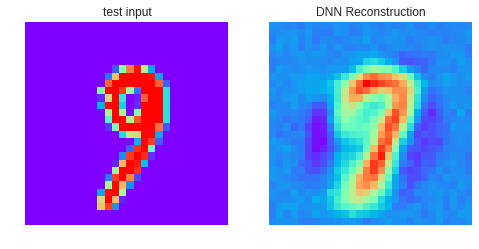

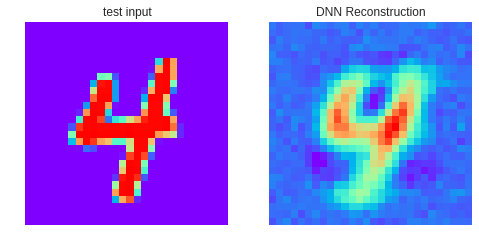

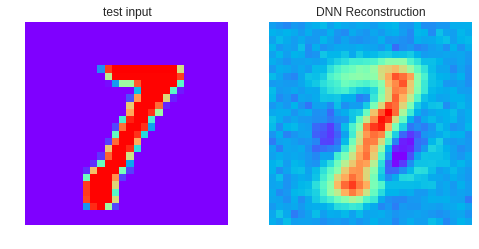

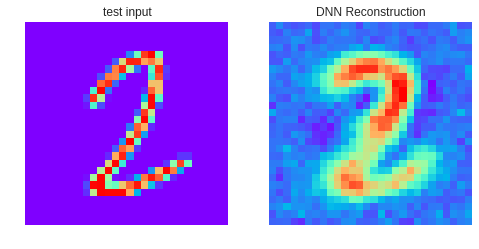

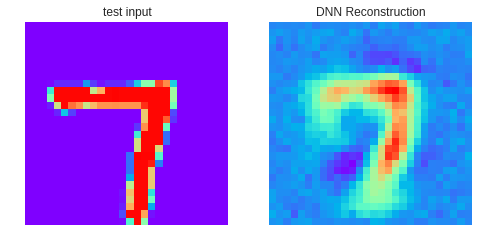

In [0]:
test_iter = iterators.SerialIterator(test, 5, repeat=False, shuffle=True)

for i in range(5):
    test_batch = test_iter.next()
    image_test, target_test = concat_examples(test_batch, gpu_id)
    reconstructed = model_inv(image_test)

for i in range(5):
    plt.subplot(1,2,1)
    plt.title('test input')
    plt.axis('off')

    img = cp.asnumpy(image_test[i])
    plt.imshow(img.reshape((28,28)), cmap=cmap)

    plt.subplot(1,2,2)
    plt.title('DNN Reconstruction')
    plt.axis('off')

    re_img = cp.asnumpy(reconstructed[i].data)
    plt.imshow(re_img.reshape((28,28)), cmap=cmap)

    plt.show()